# Generating human faces with Adversarial Networks 

In [1]:
import os
import PIL
import time
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import trange
from tensorflow.keras import layers

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
NOISE_DIM = 100

## Fetch (load) the data

In [3]:
from util import fetch_lfw_dataset, load_lfw_dataset

#data = load_lfw_dataset()
data = fetch_lfw_dataset(dimx=36,dimy=36, use_raw=False)

found lfw-deepfunneled dataset
preprocessing
done
saving
done


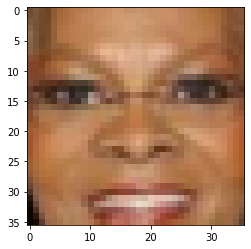

In [4]:
# Normalize inputs
norm_data = np.float32(data) / 255. #(np.float32(data) - 127.5) / 127.5

IMG_SHAPE = data.shape[1:]

plt.imshow(norm_data[np.random.randint(norm_data.shape[0])].clip(0,1))

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(norm_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

Some practical advices: [GAN Hacks](https://github.com/soumith/ganhacks)

Diagram with handwriten digets as example:
![title](https://miro.medium.com/max/2706/1*xOgw_4Wv2KHvGzm_x0zeIQ.png)


In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(9*9*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((9, 9, 256)))
    assert model.output_shape == (None, 9, 9, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 9, 9, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 18, 18, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 36, 36, 3)

    return model

Use the yet untrained generator to create an image.

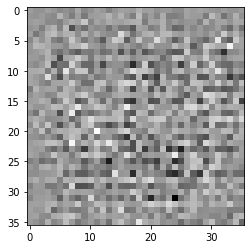

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=IMG_SHAPE))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the yet untrained discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [9]:
discriminator = make_discriminator_model()

# print decision
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00558572]], dtype=float32)>

### Loss and optimizers

__Discriminator's__ goal is to distinguish real images from fake. So the __D_loss__ compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

__Generator's__ goal is to trick the discriminator. So __G_loss__ compares the discriminators decisions on the generated images to an array of 1s.

The model perform well when it cannot tell whick image is fake

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Generator trains with **adam** to speed up training. Discriminator trains with **SGD** to avoid problems with momentum.

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.SGD(1e-3)

### Save checkpoints

In [12]:
checkpoint_dir = './training_checkpoints'   
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

### Training loop


In [13]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Auxiliary functions

In [14]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, NOISE_DIM)).astype('float32')

def sample_images(nrow, ncol, epoch, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(0,1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
            
    plt.savefig(f'./{OUTPUT_DIR}/image_at_epoch_{epoch:04d}.png')
    plt.show()

## Training

In [15]:
N_EPOCHS = 10
OUTPUT_DIR = './img/output'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

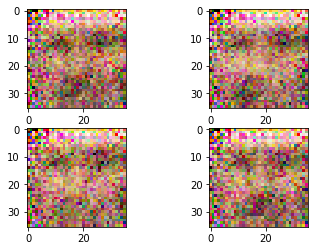

Time for epoch 10 is 39.90444302558899 sec



In [16]:
for epoch in trange(N_EPOCHS):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)

    display.clear_output(wait=True)
    sample_images(2, 2, epoch+1, True)

    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')

## Create GIF

In [17]:
import imageio
import glob

anim_file = './img/anim.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(f'./{OUTPUT_DIR}/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

## Save & Load

In [19]:
!mkdir -p saved_model
generator.save('saved_model/my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [21]:
new_model = tf.keras.models.load_model('saved_model/my_model')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20736)             2073600   
_________________________________________________________________
batch_normalization (BatchNo (None, 20736)             82944     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20736)             0         
_________________________________________________________________
reshape (Reshape)            (None, 9, 9, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 9, 9, 128)         0